In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
import numpy.random as rand
from scipy.stats import gaussian_kde as kde
from mpl_toolkits.mplot3d import Axes3D
from EDMtoolkit import *
from modelSystems import *
from sklearn.feature_selection import mutual_info_regression as mir
from scipy.stats import differential_entropy as de

%matplotlib notebook

In [13]:
# takes a time series X with shape n,m and returns a 1 x n series of integers where
# each integer uniquely identifies the binned square where that entry of the time
# series came from.
def bin_series(X, n_bins):
    X1 = np.floor((X - np.min(X, axis=0)) / np.ptp(X, axis=0) * n_bins).astype(int)
    X1 = X1 - (X1 == n_bins).astype(int)
    return X1

def compute_keys(X, n_bins):
    num_system = np.vstack(n_bins ** np.arange(0, X.shape[1]))
    return X @ num_system

def get_prob(D, i):
    return np.mean(np.all(D == i, axis=1).astype(int))      

def entropy(D):
    entropy = 0
    for m in np.unique(D, axis=0):
        p = get_prob(D, m)
        if p > 0:
            entropy -= p * np.log2(p)
    return entropy

# conditional entropy H(X|Y) where X = D[:,:i] and Y=[:,i:]
def entropy_cond(X, Y):
    return entropy(np.hstack([X,Y])) - entropy(Y)

"""
def entropy_cond(D, i, j):
    entropy = 0
    for row in np.unique(D, axis=0):
        joint = get_prob(D, row)
        individual = get_prob(D[:,i:j,None], row[i:j,None])
        entropy -= joint * np.log2(joint / individual)
    return entropy
"""

def cond_mut_inf(X, Y, Z):
    return entropy_cond(X, Z) - entropy_cond(X, np.hstack([Y, Z]))
    # return entropy(np.hstack([X, Z])) + entropy(np.hstack([Y, Z])) - entropy(np.hstack([X, Y, Z])) - entropy(Z)
    
# creates a grid of points from of shape (dim, n_points)
def create_grid(res, bounds):
    assert len(bounds) % 2 == 0
    
    dim = int(len(bounds) / 2)
    args = [np.linspace(bounds[2*i],bounds[2*i+1],num=res) for i in range(dim)]
    
    return np.array(np.meshgrid(*args)).reshape((dim, res ** dim))
    
    """
    n_rows = res ** dim
    grid = np.zeros((n_rows, dim))
    for i in range(n_rows):
        for j in range(dim):
            grid[i,j] = int(i / (res ** j)) % res / res
    
    for d in range(dim):
        grid[:,d] = grid[:,d] * (bounds[d+dim] - bounds[d]) + bounds[d]
    
    return grid
    """

def entropy_cont(dist, res, bounds):
    grid = create_grid(res, bounds)
    
    o = dist(grid.T)
    o /= np.sum(o)
    
    entropy = 0
    for p in o:
        entropy -= p * np.log2(p)
    
    return entropy

# def cond_entropy_cont(X, Y, res=10):
    

def cond_mut_inf_cont(X, Y, Z, res=10):
    assert X.shape[0] == Y.shape[0] and Y.shape[0] == Z.shape[0]
    
    n = X.shape[0]
    x_dim, y_dim, z_dim = X.shape[1], Y.shape[1], Z.shape[1]
    total_dim = x_dim + y_dim + z_dim
    
    grid = create_grid(res, [0,1]*total_dim)
    XYZ = kde(np.hstack([X, Y, Z]).T)(grid).reshape(tuple([res]*total_dim))
    
    Xi = list(range(x_dim))
    Yi = list(range(x_dim, x_dim+y_dim))
    Zi = list(range(x_dim+y_dim, total_dim))
    
    XZe = np.sum(XYZ, axis = tuple(Yi))
    YZe = np.sum(XYZ, axis = tuple(Xi))
    XYZe = XYZ
    Ze = np.sum(XYZ, axis = tuple(Xi+Yi))
    
    e_XZ = - np.sum(XZe * np.log2(XZe))
    e_YZ = - np.sum(YZe * np.log2(YZe))
    e_XYZ =  - np.sum(XYZe * np.log2(XYZe))
    e_Z = - np.sum(Ze * np.log2(Ze))
    
    return e_XZ + e_YZ - e_XYZ - e_Z

In [14]:
## Drivers ##

settlingTime = 2 ** 9
tlen = 2 ** 10
end = 2 ** 7 # 2**5 # (3.498901098901099 / (12*reduction)) * tlen # 2**3
reduction = 2 ** 0

tr = np.linspace(0, end, num=tlen)
t = tr / end

In [15]:
## Drivers ##

# r = lambda t: 4 # - t / tlen
# b1 = lambda t: 6 # 2 + 6 * t / end
# rho = lambda t : 28 + 50 * t / end
# sigma = lambda t : 10 + 10 * t / end
# beta = lambda t : 5.0 / 3.0 # + 3*t/end

F = lambda t : 5 + 15 * t / end
N = 10

In [16]:
## Time Series Generation ##

# x0 = rand.rand(1)
# Xr = generateTimeSeriesDiscrete("LogisticP", x0, tlen=tlen, nsargs=(r,), settlingTime=settlingTime)

x0 = rand.random(N)
# x0 = np.array([1,0.5,7]) - rand.random(3) * 0.1

Xr = generateTimeSeriesContinuous("Lorenz96P", x0, nsargs=(F, N), tlen=tlen, end=end, settlingTime=settlingTime, reduction= reduction)[:,N-1,None]
# Xr = generateTimeSeriesContinuous('HastingsPowellP', x0, nsargs=(b1,), end=end, tlen = tlen, reduction = reduction, settlingTime=settlingTime)[:,0,None]
# Xr = generateTimeSeriesContinuous('LorenzP', np.array([1,5,17]), nsargs=(rho, sigma, beta), tlen=tlen, end=end, settlingTime=settlingTime, reduction= reduction)[:,0,None]

## Add Noise ##
noise_magnitude = 0.5
# Xr += rand.random((Xr.shape[0],1)) * np.ptp(Xr) * noise_magnitude

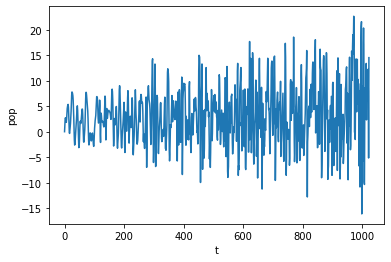

In [17]:
plotTS(Xr)

<IPython.core.display.Javascript object>


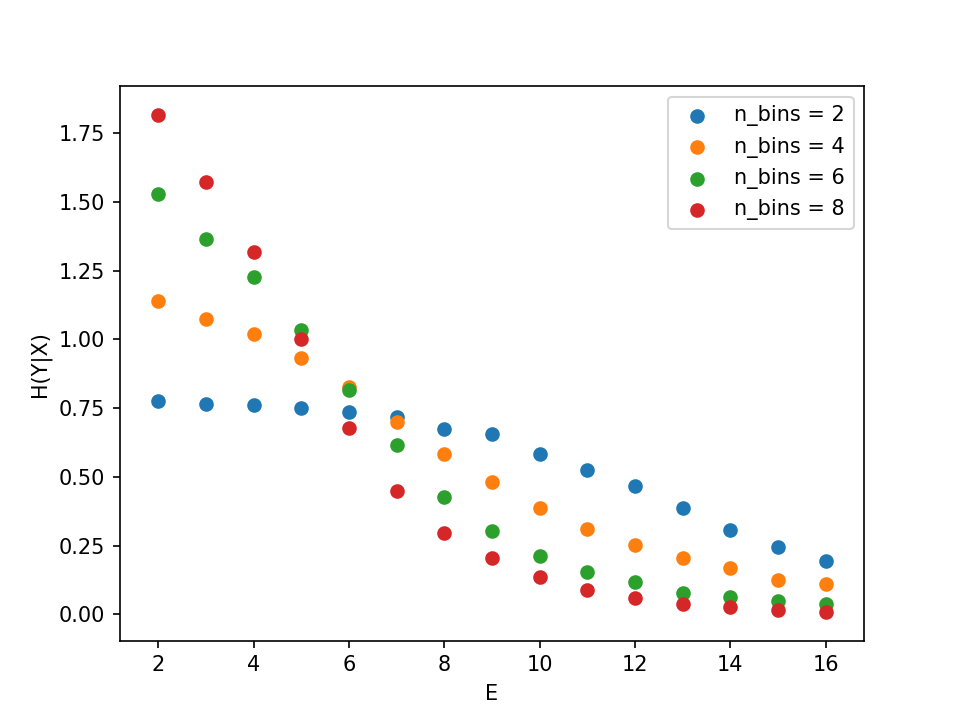

In [238]:
n_bins_range = np.arange(2,10,2)
E_max = 15
CEs = np.zeros(E_max)
figCE, axCE = plt.subplots(1)
for n_bins in n_bins_range:
    for E in range(0, E_max):
        X, Y, tf = delayEmbed(Xr, 1, E, 1, t=t)
        Xs = bin_series(X, n_bins)
        Ys = bin_series(Y, n_bins)
        
        CEs[E] = entropy_cond(Ys, Xs)
    axCE.scatter(np.arange(2,E_max+2), CEs, label=f"n_bins = {n_bins}")

axCE.set_xlabel("E")
axCE.set_ylabel("H(Y|X)")
axCE.legend()
plt.show()

In [8]:
E = 0
n_bins = 8
X, Y, tf = delayEmbed(Xr, 1, E, 1, t=t)
Z = tf[:,None]

Xt = np.hstack([X,tf[:,None]])

symbols = bin_series(Xt, n_bins)
symbols.shape[0] / np.unique(symbols, axis=0).shape[0]

20.058823529411764

<IPython.core.display.Javascript object>


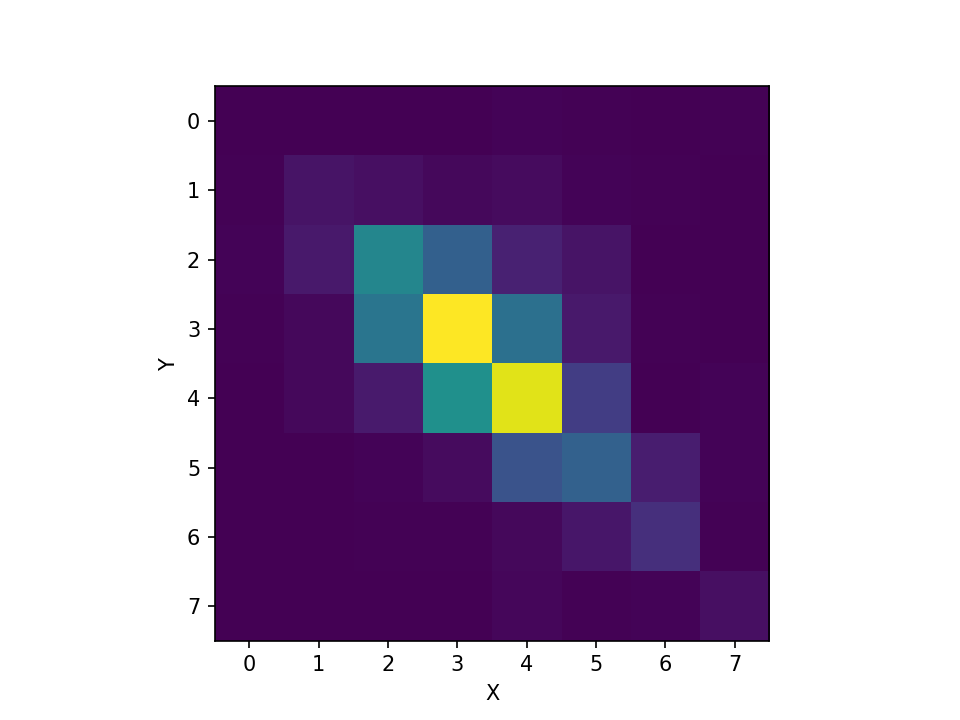

Text(0, 0.5, 'Y')

In [254]:
Xs = bin_series(X, n_bins)
Ys = bin_series(Y, n_bins)

stack = np.hstack([Ys,Xs])
unique_rows = np.unique(Xs,axis=0)
pmf = np.zeros((n_bins,unique_rows.shape[0]))
for r, row in enumerate(unique_rows):
    for c in range(n_bins):
        pmf[c,r] = get_prob(stack, np.hstack([c,row]))

entropy_cond(Xs, Ys)

fig10 = plt.figure()

plt.imshow(pmf)
plt.xlabel("X")
plt.ylabel("Y")

In [255]:
entropy_cond(Ys, Xs)

1.7588263182761632

In [12]:
- np.log2(1/tlen)

10.0

<IPython.core.display.Javascript object>


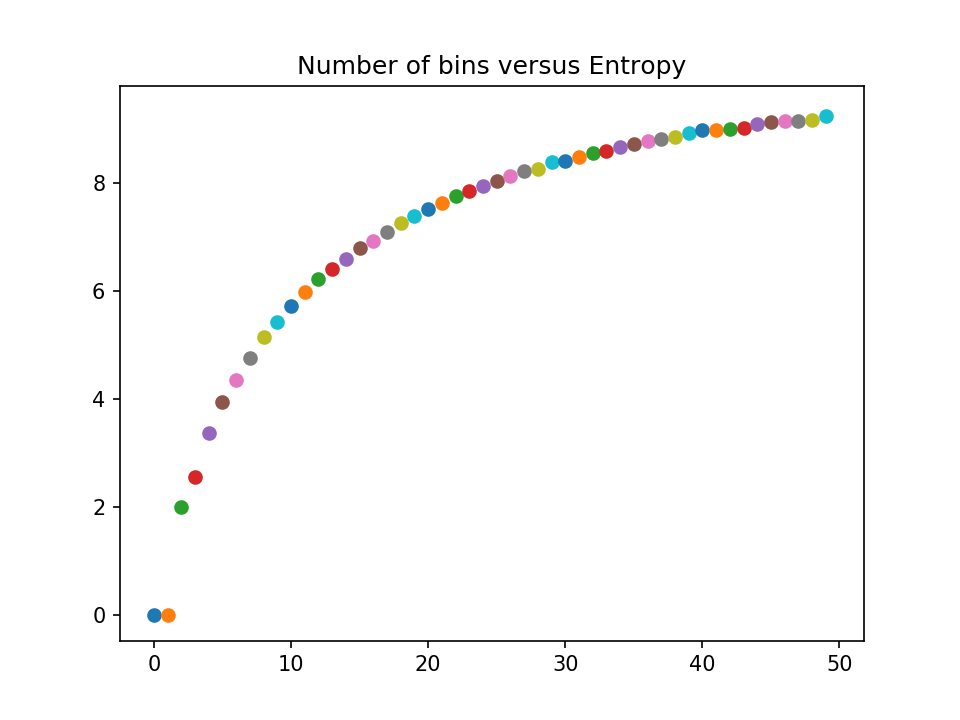

In [256]:
fig2 = plt.figure(8)
for b in range(50):
    symbols = bin_series(Xt, b)
    plt.scatter(b, entropy(symbols))
    plt.title("Number of bins versus Entropy")

In [257]:
Xs = bin_series(X, n_bins)
Ys = bin_series(Y, n_bins)
Zs = bin_series(tf[:,None], n_bins)
cond_mut_inf(Xs, Ys, Zs)

0.5873248718545239

<IPython.core.display.Javascript object>


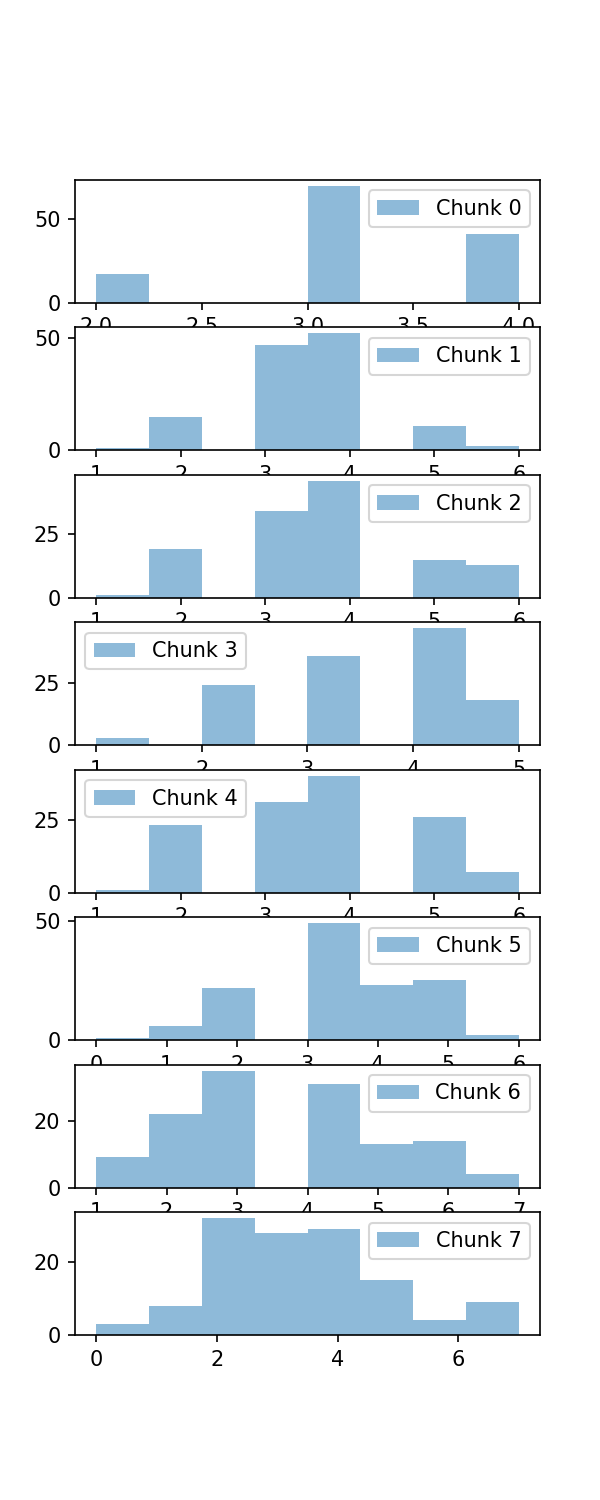

In [258]:
binned_series = bin_series(Xr,n_bins)
fig, ax = plt.subplots(n_bins, figsize=(4,10))
for i in range(n_bins):
    chunk = binned_series[int(i*tlen/n_bins):int((i+1)*tlen/n_bins),0]
    ax[i].hist(chunk, label = f"Chunk {i}", alpha = 0.5, bins=n_bins)
    ax[i].legend()

In [ ]:
n_trials = 50
results = np.zeros((n_trials, 2))
for i in range(n_trials):
    rate = rand.random(1)
    
    # r = lambda t: 4 - rate * t / tlen
    # x0 = rand.rand(1)
    # Xr = generateTimeSeriesDiscrete("LogisticP", x0, tlen=tlen, nsargs=(r,), settlingTime=settlingTime)
    
    # b1 = lambda t: 3 + rate * 5 * t / end
    # x0 = np.array([1,0.5,7]) - rand.random(3) * 0.1
    # Xr = generateTimeSeriesContinuous('HastingsPowellP', x0, nsargs=(b1,), end=end, tlen = tlen, reduction = reduction, settlingTime=settlingTime)[:,0,None]
    
    F = lambda t : 5 + rate * 15 * t / end
    N = 10
    x0 = rand.random(N)
    print("Integration Start")
    Xr = generateTimeSeriesContinuous("Lorenz96P", x0, nsargs=(F, N), tlen=tlen, end=end, settlingTime=settlingTime, reduction= reduction)[:,N-1,None]
    print("Integration End")
    
    
    X, Y, Z = delayEmbed(Xr, 1, E, 1, t=t)
    Z = Z[:,None]
    
    # results[i,1] = cond_mut_inf_cont(Y, Z, X)
    # results[i,1] = np.sum(mir(np.hstack([X, Z]) , Y)) - np.sum(mir(X, Y))
    
    results[i,0] = rate
    
    A = bin_series(X, n_bins)
    B = bin_series(Y, n_bins)
    C = bin_series(Z, n_bins)
    results[i,1] = cond_mut_inf(B, C, A)
    
    print(rate, results[i,1])

Integration Start
Integration End
[0.18094965] 0.19262547504477512
Integration Start
Integration End
[0.18608582] 0.1603218073521142
Integration Start
Integration End
[0.22865843] 0.15655609956705163
Integration Start
Integration End
[0.9239681] 0.22062439913858878
Integration Start
Integration End
[0.68545978] 0.17308598709435286
Integration Start
Integration End
[0.34722568] 0.1572755617567716
Integration Start
Integration End
[0.0129796] 0.1195688202592411
Integration Start
Integration End
[0.3659287] 0.18459442847276009
Integration Start
Integration End
[0.95562176] 0.2238410836289222
Integration Start
Integration End
[0.51872714] 0.19117290002701726
Integration Start
Integration End
[0.0874851] 0.11444235809394732
Integration Start
Integration End
[0.60078064] 0.19169006248206477
Integration Start
Integration End
[0.38225655] 0.192541505191258
Integration Start
Integration End
[0.73188433] 0.2305837848744159
Integration Start
Integration End
[0.63923823] 0.18429197625125138
Integr

<IPython.core.display.Javascript object>


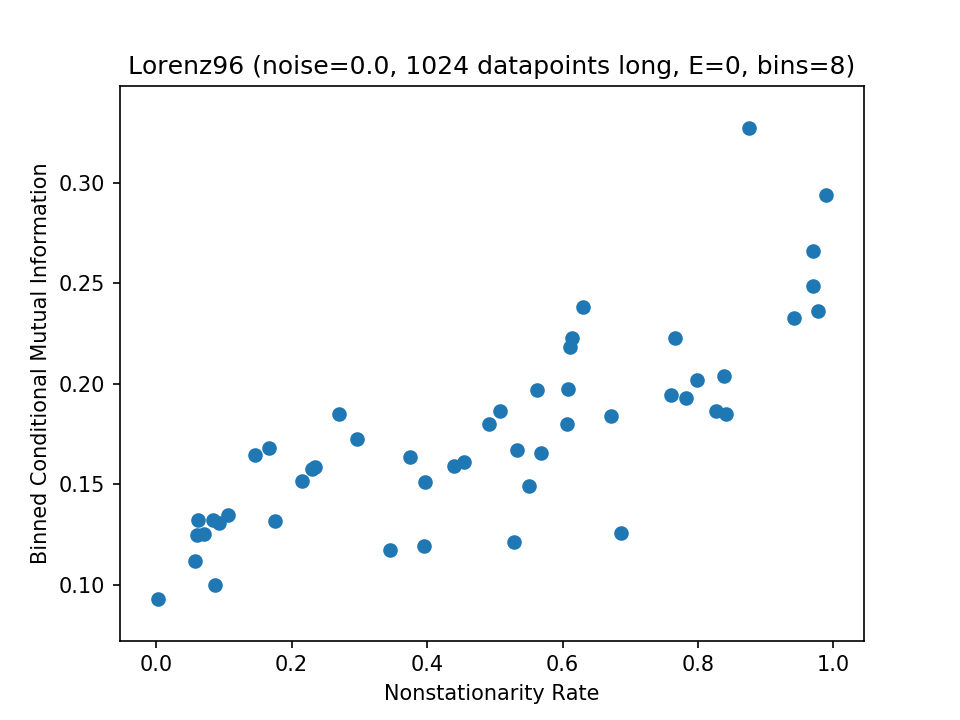

Text(0.5, 0, 'Nonstationarity Rate')

In [259]:
fig = plt.figure()
plt.scatter(results[:,0], results[:,1])
# plt.title(f"Hastings Powell (noise=0.0, {tlen} datapoints long, bins={n_bins}, E={E+2})")
# plt.title(f"Logistic (noise=0.0, {tlen} datapoints long, E={E}, bins={n_bins})")
plt.title(f"Lorenz96 (noise=0.0, {tlen} datapoints long, E={E}, bins={n_bins})")
# plt.title(f"Hastings Powell (noise=0.0, {tlen} datapoints long, E={E})")
# plt.ylabel("Continuous Conditional Mutual Information")
plt.ylabel("Binned Conditional Mutual Information")
plt.xlabel("Nonstationarity Rate")

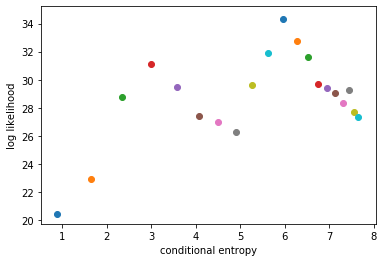

In [188]:
n_bins = 3
E_max = 20

fig, ax = plt.subplots(1)

for E in range(E_max):
    X, Y, tf = delayEmbed(Xr, 1, E, 1, t=t)
    A = bin_series(X, n_bins)
    B = bin_series(Y, n_bins)
    C = tf[:,None]
    
    ax.scatter(entropy_cond(A,B), logLikelihood(X, Y, tf, 0, 0))

ax.set_xlabel("conditional entropy")
ax.set_ylabel("log likelihood")
plt.show()

In [726]:
def testing():
    S1=np.array([[0],
             [0],
             [1],
             [1]])
    S2=np.array([[0,0],
             [0,1],
             [1,0],
             [1,1]])
    
    assert entropy(S1) == 1
    assert entropy(S2) == 2
    assert entropy_cond(S2, S1) == 1
    assert entropy_cond(S1, S2) == 0
    
testing()

In [791]:
test_kde = kde(Xt.T, bw_method="scott")

In [802]:
grid = create_grid(dim, res, [-1, -1, 2, 2])

<IPython.core.display.Javascript object>


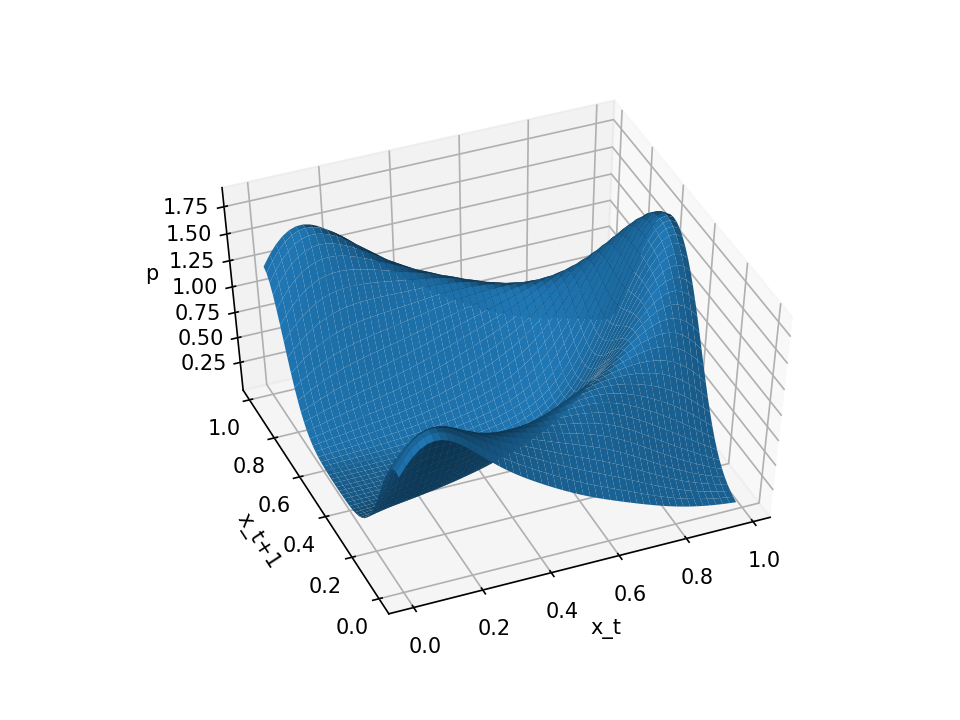

Text(0.5, 0, 'p')

In [814]:
res = 50
dim = Xt.shape[1]
bounds = [0, 0, 1, 1]
grid = create_grid(dim, res, bounds)

u1 = grid[:,0].reshape((res,res))
u2 = grid[:,1].reshape((res,res))
o = test_kde(grid.T).reshape((res, res))

fig = plt.figure()
ax = plt.gca(projection="3d")
ax.plot_surface(u1, u2, o)
ax.set_xlabel("x_t")
ax.set_ylabel("x_t+1")
ax.set_zlabel("p")

In [821]:
test_entropy = entropy_cont(test_kde, dim, res, bounds)

<IPython.core.display.Javascript object>


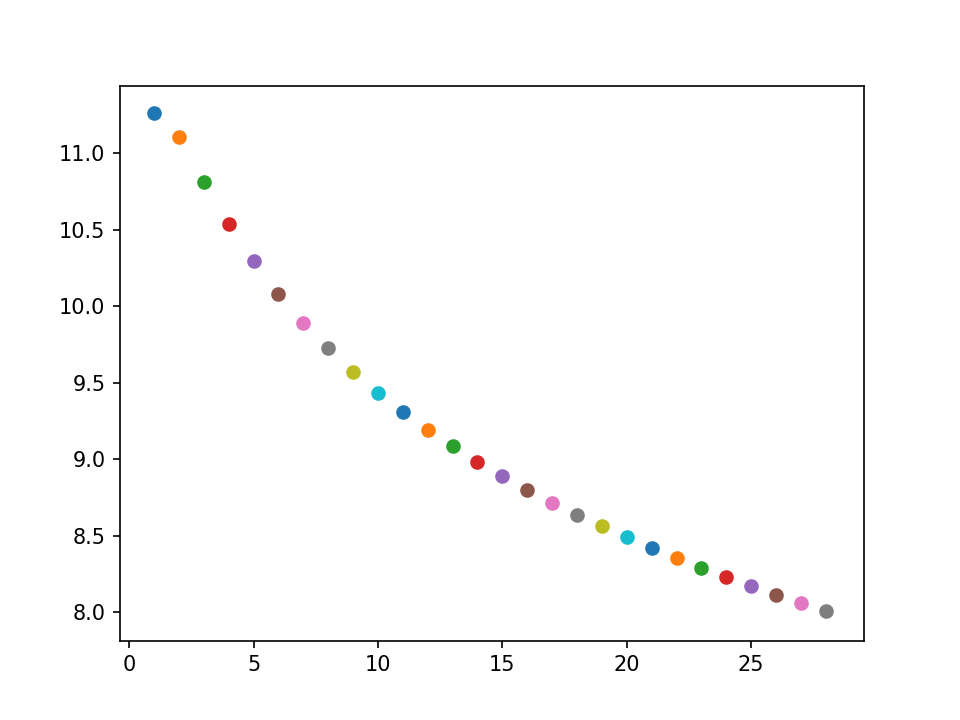

c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [832]:
fig3 = plt.figure(4)
for b in range(1,50):
    test_kde = kde(Xt.T, bw_method=1/b)
    plt.scatter(b, entropy_cont(test_kde, dim, res, bounds))